In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore", category=RuntimeWarning)

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

In [3]:
train_df.head(5)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [4]:
train_df.head(5)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [5]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     -------------- 

In [6]:
train_df.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [7]:
print("Train data", train_df.nunique())
print("\nTest data",test_df.nunique())

Train data id                           18524
Time_spent_Alone                12
Stage_fear                       2
Social_event_attendance         11
Going_outside                    8
Drained_after_socializing        2
Friends_circle_size             16
Post_frequency                  11
Personality                      2
dtype: int64

Test data id                           6175
Time_spent_Alone               12
Stage_fear                      2
Social_event_attendance        11
Going_outside                   8
Drained_after_socializing       2
Friends_circle_size            16
Post_frequency                 11
dtype: int64


In [8]:
col_list = train_df.columns.to_list()
col_list

['id',
 'Time_spent_Alone',
 'Stage_fear',
 'Social_event_attendance',
 'Going_outside',
 'Drained_after_socializing',
 'Friends_circle_size',
 'Post_frequency',
 'Personality']

In [9]:
col_to_remove = ['id']
list_for_value_count = [x for x in col_list if x not in col_to_remove]
for i in list_for_value_count:
    print(train_df[i].value_counts())

Time_spent_Alone
0.0     3139
3.0     3081
2.0     3039
1.0     2973
4.0     1079
5.0      633
10.0     587
8.0      582
7.0      581
6.0      574
9.0      574
11.0     492
Name: count, dtype: int64
Stage_fear
No     12609
Yes     4022
Name: count, dtype: int64
Social_event_attendance
4.0     2073
9.0     2063
7.0     2031
5.0     1985
6.0     1984
8.0     1945
3.0     1703
2.0     1063
0.0     1055
1.0      978
10.0     464
Name: count, dtype: int64
Going_outside
5.0    2923
3.0    2822
4.0    2703
6.0    2702
7.0    2170
0.0    1324
2.0    1279
1.0    1135
Name: count, dtype: int64
Drained_after_socializing
No     13313
Yes     4062
Name: count, dtype: int64
Friends_circle_size
5.0     1669
4.0     1317
12.0    1317
8.0     1281
10.0    1267
11.0    1253
14.0    1188
6.0     1146
7.0     1124
9.0     1061
13.0    1048
15.0     943
3.0      866
2.0      770
1.0      753
0.0      467
Name: count, dtype: int64
Post_frequency
3.0     2258
7.0     1827
5.0     1788
6.0     1767
9.0     17

In [10]:
print("Duplicates in train data:", train_df.duplicated().sum())
print("Duplicates in test data:", test_df.duplicated().sum())

Duplicates in train data: 0
Duplicates in test data: 0


In [11]:
print("Missing values in train data:\n",train_df.isna().mean().apply(lambda x: f"{x:.2%}"))
print("\nMissing values  in test data:\n",test_df.isna().mean().apply(lambda x: f"{x:.2%}"))

Missing values in train data:
 id                            0.00%
Time_spent_Alone              6.42%
Stage_fear                   10.22%
Social_event_attendance       6.37%
Going_outside                 7.91%
Drained_after_socializing     6.20%
Friends_circle_size           5.69%
Post_frequency                6.82%
Personality                   0.00%
dtype: object

Missing values  in test data:
 id                           0.00%
Time_spent_Alone             6.88%
Stage_fear                   9.68%
Social_event_attendance      6.43%
Going_outside                7.55%
Drained_after_socializing    7.00%
Friends_circle_size          5.67%
Post_frequency               6.61%
dtype: object


<Axes: >

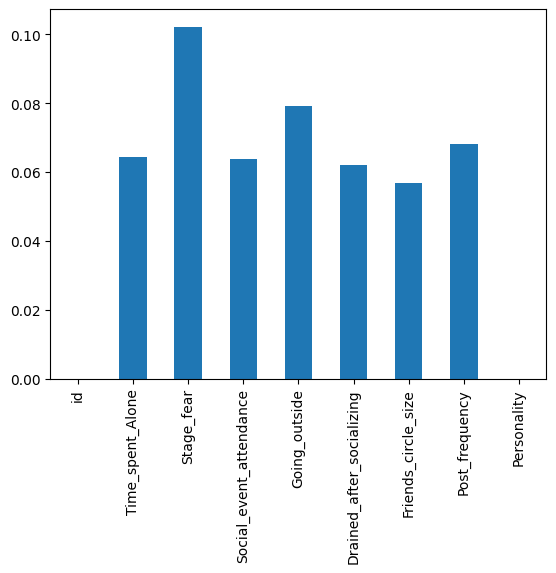

In [12]:
train_df.isna().mean().plot.bar()

Personality
Extrovert    73.95
Introvert    26.05
Name: proportion, dtype: float64

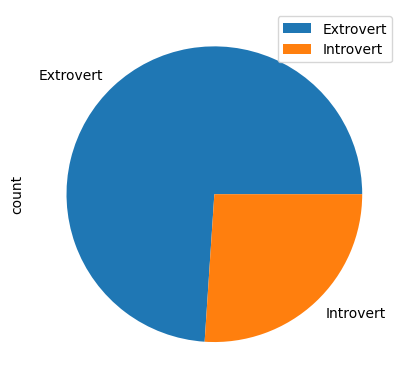

In [13]:
train_df['Personality'].value_counts().plot(kind='pie', legend=True)
round(train_df['Personality'].value_counts(normalize=True)*100,2)

Personality,Extrovert,Introvert
Time_spent_Alone,,
0.0,98.0,2.0
1.0,98.0,2.0
2.0,98.0,2.0
3.0,98.0,2.0
4.0,51.0,49.0
5.0,9.0,91.0
6.0,10.0,90.0
7.0,7.0,93.0
8.0,6.0,94.0


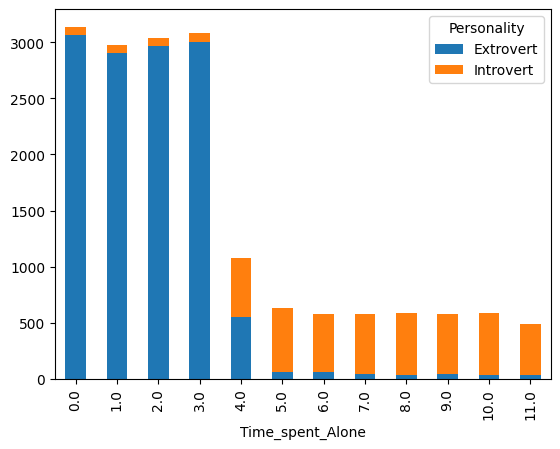

In [14]:

train_df.groupby(['Time_spent_Alone','Personality']).size().unstack().plot(kind='bar', stacked=True)
train_df.groupby('Time_spent_Alone')['Personality'].value_counts(normalize=True).unstack().round(2)*100


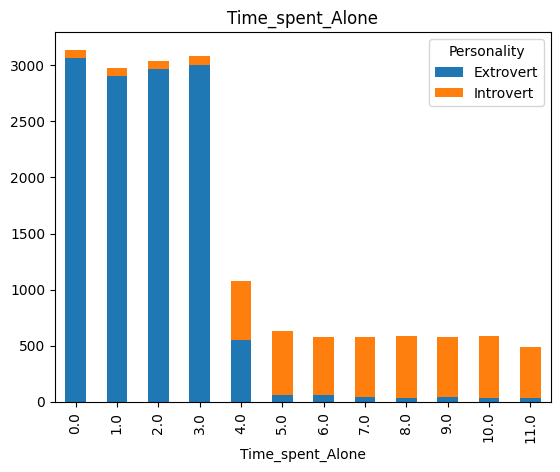

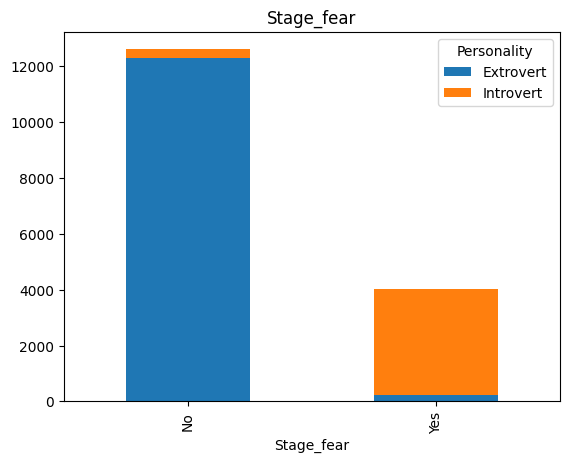

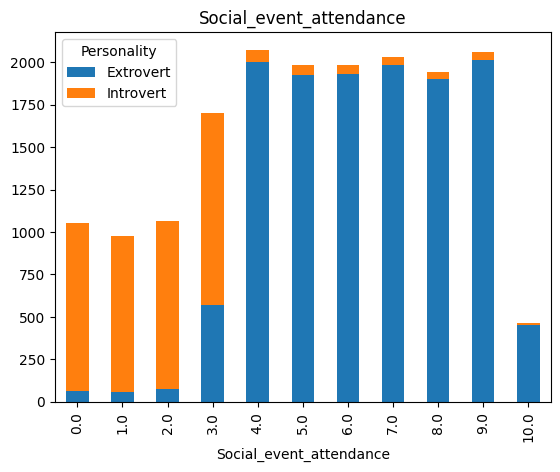

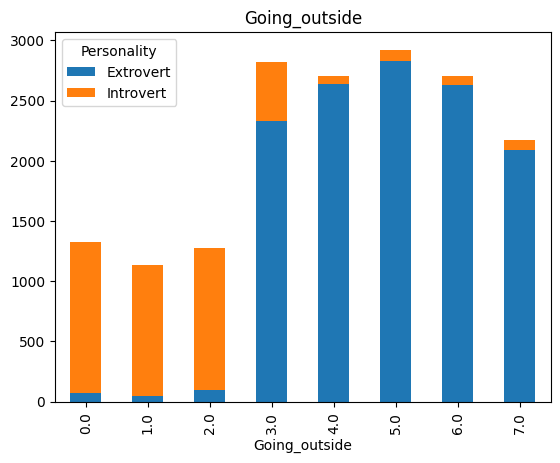

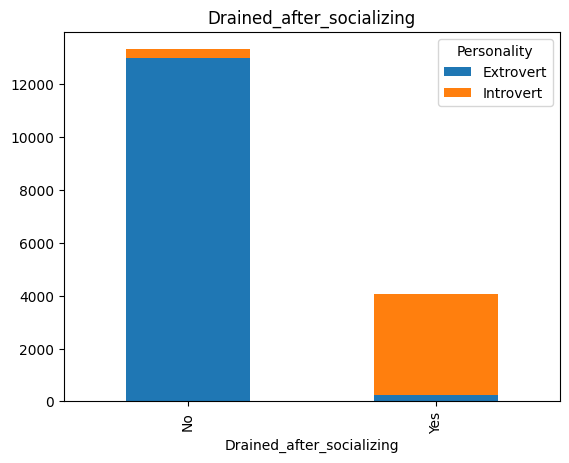

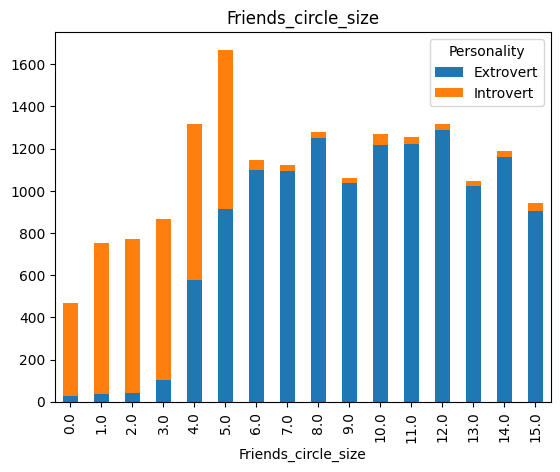

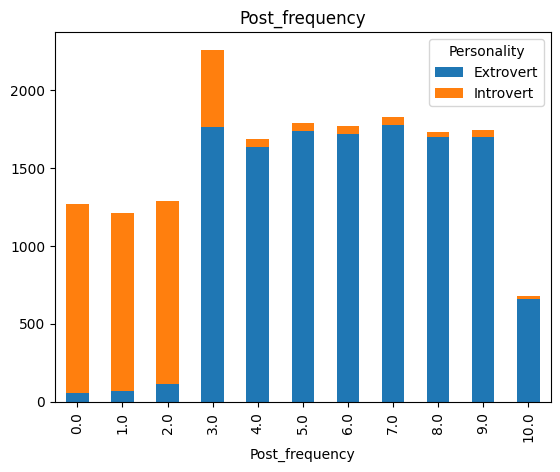

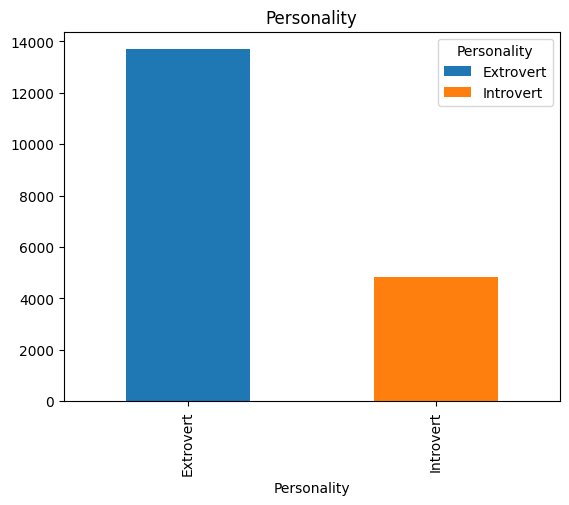

In [15]:
for i in list_for_value_count:
    train_df.groupby([i,'Personality']).size().unstack().plot(kind='bar', stacked=True, title=i)

In [16]:
train_df[['Time_spent_Alone','Social_event_attendance','Going_outside','Friends_circle_size','Post_frequency']].corr()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
Time_spent_Alone,1.000000,-0.628806,-0.640884,-0.598014,-0.611544
Social_event_attendance,-0.628806,1.000000,0.585224,0.566675,0.566679
Going_outside,-0.640884,0.585224,1.000000,0.549864,0.579305
Friends_circle_size,-0.598014,0.566675,0.549864,1.000000,0.522272
Post_frequency,-0.611544,0.566679,0.579305,0.522272,1.000000


In [17]:
for column in train_df.columns:
    mode_value = train_df[column].mode(dropna=True)
    if not mode_value.empty:
        train_df[column].fillna(mode_value[0], inplace=True)

/tmp/ipykernel_35/4012104913.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[column].fillna(mode_value[0], inplace=True)


In [18]:
df.isnull().sum().sort_values(ascending=False)

NameError: name 'df' is not defined

In [ ]:
col_list.remove('id')
col_list.remove('Personality')

In [ ]:
col_list

In [ ]:
test_data = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')
test_X = test_data[col_list].copy()
for column in test_X.columns:
    mode_value = test_X[column].mode(dropna=True)
    if not mode_value.empty:
        test_X[column].fillna(mode_value[0], inplace=True)
print(test_X.isnull().sum().sort_values(ascending=False))
test_X.head(5)

In [ ]:
df_train = df.drop(['id','Personality'], axis=1).copy()
df_test = test_X.copy()
y = df['Personality'].copy()
categorical_cols = col_list

In [ ]:
# Zakładam, że masz: 
# df_train — dane treningowe (bez SalePrice)
# df_test — dane testowe (do predykcji)
# y — target
# numerical_cols — lista kolumn numerycznych
# categorical_cols — lista kolumn kategorycznych

# 1. Wyciągamy tylko kolumny

X_train_cat = pd.get_dummies(df_train[categorical_cols], drop_first=True)
X_test_cat  = pd.get_dummies(df_test[categorical_cols], drop_first=True)

# 2. Dopasuj kolumny OneHotEncodera między train i test
X_train_cat, X_test_cat = X_train_cat.align(X_test_cat, join="left", axis=1, fill_value=0)

# 3. Sklejamy numeryczne + zakodowane kategorie
X_train_final = X_train_cat
X_test_final  = X_test_cat



In [ ]:
X_test_final.head(1)

In [ ]:
col_float= ['Time_spent_Alone','Social_event_attendance','Going_outside',
              'Friends_circle_size','Post_frequency']

In [ ]:
X_train_final[col_float]=X_train_final[col_float].astype('Int64')
X_test_final[col_float]=X_test_final[col_float].astype('Int64')
X_test_final.head(1)

In [ ]:
cat_features = X_test_final.columns.to_list()

In [ ]:
# 4. Trenujemy model

model = CatBoostClassifier(
                            cat_features=cat_features,
                            iterations=800, #1000 najlepszy
                            learning_rate=0.05, #0.05 najlepszy
                            depth=6,
                            auto_class_weights = None,   # najlepszy'Balanced',
                            verbose=0
                          )

model.fit(X_train_final, y)

# 5. Predykcja na test.csv (do submission)
preds = model.predict(X_test_final)

In [ ]:
df_test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

submission = pd.DataFrame({
    "id": df_test["id"],
    "Personality": preds
})
submission.to_csv("submission.csv", index=False)

print('Sukcesss!!!')